In [1]:
import os
import sys
sys.path.insert(0, "..")
import inspect
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from tqdm import tqdm

import matplotlib.pyplot as plt

from models import *
from my_datasets import *
from experiments import *
from experiments.utils.model_loader_utils import *

torch.set_printoptions(sci_mode=False, precision=2, linewidth=120)

In [2]:
n, d, k = 48, 96, 3
path = f"/home/antonxue/foo/tf_logic/_dump/learned_attacks/suppress_rules_learned_n{n}_d{d}_k{k}_repeat_best.pt"
state_dict = torch.load(path)["model_state_dict"]

In [3]:
res_model, res_dataset = load_model_and_dataset_from_big_grid(embed_dim=d, num_vars=n, seed=601)
atk_model = SuppressRuleWrapperModel(res_model, num_attack_tokens=k)
atk_model.load_state_dict(state_dict)

Querying id: model-SynSAR_gpt2_d96_L1_H1__DMY_nv48_nr32_exph3.000__ntr262144_ntt65536_bsz512_steps8192_lr0.00050_seed601:v0
Downloading: <Artifact QXJ0aWZhY3Q6ODI4ODExOTMz>


wandb:   2 of 2 files downloaded.  


<All keys matched successfully>

In [4]:
supp_dataset = SuppressRuleDataset(res_dataset, 1024)
dataloader = DataLoader(supp_dataset, batch_size=3)
for batch in dataloader:
    tokens = batch["tokens"]
    labels = batch["labels"]
    infos = batch["infos"]
    supp_idx = batch["supp_idx"]
    a, b = infos[:,0], infos[:,1]

    to_supp_rule = torch.cat([F.one_hot(a,n), F.one_hot(b,n)], dim=-1)    
    to_supp_ind = (tokens == to_supp_rule.view(-1,1,2*n)).all(dim=-1)
    break

with torch.no_grad():
    atk_out = atk_model(tokens=tokens, infos=infos, labels=labels)
    atk_rules = atk_out.logits
    adv_tokens = torch.cat([atk_rules, tokens], dim=1)
    adv_out = atk_model.reasoner_model(tokens=adv_tokens, output_attentions=True)
    adv_pred = adv_out.logits > 0

In [5]:
supp_idx

tensor([25, 27,  5])

In [6]:
tokens[0].sum(dim=-1) == 2

tensor([False, False, False, False, False, False, False, False,  True, False, False, False, False,  True, False, False,
        False, False, False, False, False, False, False, False, False,  True, False, False, False, False, False, False])

In [7]:
tokens.shape

torch.Size([3, 32, 96])

In [8]:
tokens.size()

torch.Size([3, 32, 96])

In [9]:
tokens[-1,1]

tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [10]:
to_supp_ind

tensor([[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,  True, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False, False,  True, False, False, False, False],
        [False, False, False, False, False,  True, False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]])

In [11]:
supp_idx

tensor([25, 27,  5])

In [12]:
to_supp_ind.nonzero()

tensor([[ 0, 25],
        [ 1, 27],
        [ 2,  5]])

In [13]:
a, b

(tensor([47,  6, 32]), tensor([33,  1, 36]))

In [14]:
tokens[0,15].nonzero()

tensor([[ 0],
        [11],
        [14],
        [16],
        [47],
        [72],
        [95]])

In [15]:
adv_out.logits.shape

torch.Size([3, 3, 48])

In [16]:
out1, out2, out3 = adv_out.all_seqcls_outputs

In [17]:
attn1, = out1.attentions
attn2, = out2.attentions
attn3, = out3.attentions

In [18]:
attn1.shape

torch.Size([3, 1, 35, 35])

<Figure size 640x480 with 0 Axes>

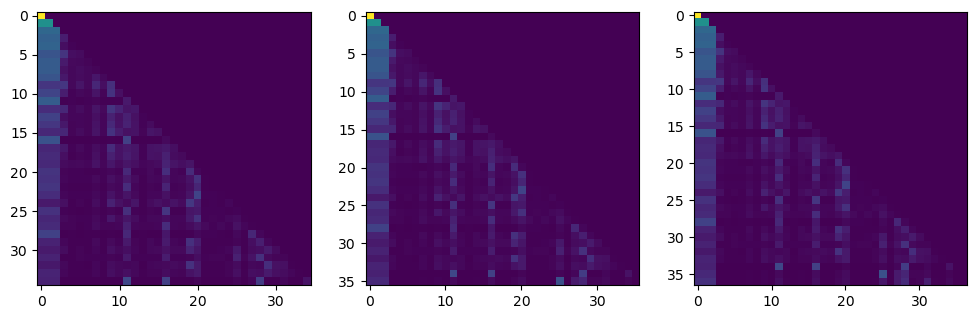

In [19]:
plt.clf()
fig, ax = plt.subplots(1,3, figsize=(12,6))
ax[0].imshow(attn1[0,0].numpy())
ax[1].imshow(attn2[0,0].numpy())
ax[2].imshow(attn3[0,0].numpy())

In [20]:
x = torch.rand(5,4)
x

tensor([[0.74, 0.85, 0.03, 0.57],
        [0.44, 0.83, 0.25, 0.55],
        [0.15, 0.28, 0.70, 0.19],
        [0.68, 0.00, 0.08, 0.41],
        [0.14, 0.62, 0.86, 0.65]])

In [21]:
perm = torch.randperm(x.size(0))
y = x[perm]
y

tensor([[0.44, 0.83, 0.25, 0.55],
        [0.14, 0.62, 0.86, 0.65],
        [0.68, 0.00, 0.08, 0.41],
        [0.74, 0.85, 0.03, 0.57],
        [0.15, 0.28, 0.70, 0.19]])

In [22]:
perm, perm.argsort()

(tensor([1, 4, 3, 0, 2]), tensor([3, 0, 4, 2, 1]))

In [23]:
attn1

tensor([[[[    1.00,     0.00,     0.00,  ...,     0.00,     0.00,     0.00],
          [    0.50,     0.50,     0.00,  ...,     0.00,     0.00,     0.00],
          [    0.33,     0.33,     0.33,  ...,     0.00,     0.00,     0.00],
          ...,
          [    0.07,     0.07,     0.07,  ...,     0.00,     0.00,     0.00],
          [    0.10,     0.10,     0.10,  ...,     0.02,     0.00,     0.00],
          [    0.09,     0.09,     0.09,  ...,     0.00,     0.00,     0.05]]],


        [[[    1.00,     0.00,     0.00,  ...,     0.00,     0.00,     0.00],
          [    0.50,     0.50,     0.00,  ...,     0.00,     0.00,     0.00],
          [    0.33,     0.33,     0.33,  ...,     0.00,     0.00,     0.00],
          ...,
          [    0.05,     0.05,     0.05,  ...,     0.02,     0.00,     0.00],
          [    0.07,     0.07,     0.07,  ...,     0.02,     0.01,     0.00],
          [    0.09,     0.09,     0.09,  ...,     0.00,     0.00,     0.05]]],


        [[[    1.00,     0

In [24]:
adv_pred = 

SyntaxError: invalid syntax (4021670746.py, line 1)

In [ ]:
y = torch.randn(2,3,4)
y

In [ ]:
to_supp_ind = (tokens == to_supp_rule).all(dim=-1)
to_supp_ind.shape, to_supp_ind

In [ ]:
to_supp_ind.all(dim=(1,2))

In [ ]:
where = torch.where((tokens == to_supp_rule).float().mean(dim=-1) > 0.999, 1, 0)

In [ ]:
where.nonzero(as_tuple=True)

In [ ]:
where[where.nonzero()]

In [ ]:
z = torch.randn(3,4,5,6)

In [ ]:
z.nonzero().shape

In [ ]:
z.nonzero(as_tuple=True)

In [ ]:
to_supp_rule.shape

In [ ]:
(tokens == to_supp_rule).float().mean(dim=-1)

In [ ]:
rule1_ante

In [ ]:
a, b

In [ ]:
rule1_ante.shape

In [ ]:
rule1_ante[:,a]

In [ ]:
rule1_conseq[:,b]

In [ ]:
atk_ante, atk_conseq = out.logits.chunk(2, dim=-1)

In [ ]:
plt.clf()
fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].plot(atk_ante[0][0].numpy())
ax[1].plot(atk_conseq[0][0].numpy())

In [ ]:
atk_conseq

In [ ]:
rule1_ante, rule1_conseq = tokens

In [ ]:
n = 48
# res_model = TheoryAutoregKStepsModel(n, 3)
# res_dataset = AutoregCustomTokensDataset(n, 32, 3.0, 1024)


dataset = KnowledgeAmnesiaDataset(res_dataset, 1024)
dataloader = DataLoader(dataset, batch_size=1)

In [ ]:
for batch in dataloader:
    tokens = batch["tokens"]
    abcdefgh = batch["abcdefgh"]
    labels = batch["labels"]
    break

In [ ]:
a, b, c, d, e, f, g, h = abcdefgh.chunk(8, dim=-1)
atk_rule = torch.cat([F.one_hot(a,n), -1*F.one_hot(a,n)], dim=-1)
atk_rules = atk_rule.view(-1,1,2*n).repeat(1,10,1)
adv_tokens = torch.cat([atk_rules, tokens], dim=1)

In [ ]:
res_out = res_model(tokens=adv_tokens)
adv_pred = (res_out.logits > 0).long()
adv_pred

In [ ]:
labels

In [ ]:
adv_pred == labels

In [ ]:
((adv_pred == labels) == 0).nonzero()

In [ ]:
a,

In [ ]:
dataset = AutoregDiamondTokensDataset(8, 32, 4.0, 10000)
dataloader = DataLoader(dataset, batch_size=4)

In [ ]:
num_dones, num_hits = 0, 0
pbar = tqdm(dataloader)
for batch in pbar:
    tokens, labels = batch["tokens"], batch["labels"]
    out = model(tokens=tokens, labels=labels)
    pred = (out.logits > 0).long()
    num_dones += tokens.size(0)
    num_hits += (labels == pred).float().mean(dim=(1,2)).sum()
    acc = num_hits / num_dones
    desc = f"acc {acc:.3f}"
    pbar.set_description(desc)

In [ ]:
batch["abcdefgh"]

In [ ]:
(tokens[0][:,7] == 1).sum()

In [ ]:
n = 16
_, res_dataset = load_model_and_dataset_from_big_grid(2*n, n)
model = TheoryAutoregKStepsModel(num_vars=n, num_steps=3)

In [ ]:
atk_dataset = KnowledgeAmnesiaDataset(res_dataset, dataset_len = 1024)
dataloader = DataLoader(atk_dataset, batch_size=3)

In [ ]:
for batch in dataloader:
    tokens = batch["tokens"]
    abcde = batch["abcde"]
    adv_labels = batch["labels"]
    break

In [ ]:
a, b, c, d, e = abcde.chunk(5, dim=-1)

In [ ]:
atk_rule = torch.cat([F.one_hot(a,n), -1000*F.one_hot(a,n)], dim=-1).view(-1,1,2*n)

In [ ]:
adv_tokens = torch.cat([atk_rule, tokens], dim=1)

In [ ]:
adv_out = model(tokens=adv_tokens)

In [ ]:
adv_pred = (adv_out.logits > 0).long()

In [ ]:
adv_pred

In [ ]:
adv_labels = batch["labels"]

In [ ]:
atk_rule = 